# Eye Tracker Data Analysis


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import seaborn as sns
import pingouin as pg


## Pre-processing


Clean up raw data from eye tracker software so it's easier to work with:


In [2]:
raw_data_dir = raw_dir = 'Eye Tracker Data/Raw CSVs'
processed_dir = 'Eye Tracker Data/Processed CSVs'

os.makedirs(processed_dir, exist_ok=True)

keywords = {
    'rec_time': 'rec_time',
    'gaze_x': 'Gaze_Gaze X',
    'gaze_y': 'Gaze_Gaze Y',
    'pupil_x': 'Original_Pupil X',
    'pupil_y': 'Original_Pupil Y'
}

for filename in os.listdir(raw_dir):
    if filename.endswith('_CsvData.txt'):
        # extract participant & trial number from text file names
        name_parts = filename.split('_')
        participant = name_parts[0]
        trial_part = name_parts[1].split('. ')[1]
        trial_number = trial_part.split('_')[0]
        new_filename = f"{participant}_{trial_number}.csv"

        input_path = os.path.join(raw_dir, filename)
        output_path = os.path.join(processed_dir, new_filename)

        df = pd.read_csv(input_path, sep='\t', encoding='utf-8', engine='python')
        df.columns = df.columns.str.strip()

        rec_time_col = next((col for col in df.columns if keywords['rec_time'] in col), None)

        # try to find gaze x & y columns first
        x_col = next((col for col in df.columns if keywords['gaze_x'] in col), None)
        y_col = next((col for col in df.columns if keywords['gaze_y'] in col), None)

        # if gaze x & y not found, use pupil x & y columns instead
        if not x_col or not y_col:
            x_col = next((col for col in df.columns if keywords['pupil_x'] in col), None)
            y_col = next((col for col in df.columns if keywords['pupil_y'] in col), None)

        if not rec_time_col or not x_col or not y_col:
            print(f"{filename} missing required columns.")
            continue

        # rename columns
        df_filtered = df[[rec_time_col, x_col, y_col]]
        df_filtered.columns = ['rec_time', 'x', 'y']

        # fix time formatting
        df_filtered.loc[:, 'rec_time'] = df_filtered['rec_time'].astype(str).str.replace('.', ':', regex=False)

        # write new CSV, named by participant name & trial only
        df_filtered.to_csv(output_path, index=False)

Independent variable values for each trial for reference:


In [5]:
trial_IVs = {
    1: {
        "driver_direction": "Left", 
        "alert_combination": "Sign 2 + crosswalk", 
        "pedestrian_crossing": "Straight ahead"
    },
    2: {
        "driver_direction": "Straight (left lane)", 
        "alert_combination": "Crosswalk", 
        "pedestrian_crossing": "To driver’s left"
    },
    3: {
        "driver_direction": "Straight (right lane)", 
        "alert_combination": "No alert", 
        "pedestrian_crossing": "To driver’s left"
    },
    4: {
        "driver_direction": "Straight (right lane)", 
        "alert_combination": "Sign 2 + crosswalk", 
        "pedestrian_crossing": "To driver’s right"
    },
    5: {"driver_direction": "Left", 
        "alert_combination": "Sign 3", 
        "pedestrian_crossing": "To driver’s left"
    },
    6: {
        "driver_direction": "Straight (left lane)", 
        "alert_combination": "No alert", 
        "pedestrian_crossing": "To driver’s right"
    },
    7: {
        "driver_direction": "Left", 
        "alert_combination": "Sign 3 + crosswalk", 
        "pedestrian_crossing": "To driver’s left"
    },
    8: {
        "driver_direction": "Left", 
        "alert_combination": "Sign 3 + crosswalk", 
        "pedestrian_crossing": "Straight ahead"
    },
    9: {
        "driver_direction": "Straight (right lane)", 
        "alert_combination": "Sign 3", 
        "pedestrian_crossing": "Straight ahead"
    },
    10: {
        "driver_direction": "Right", 
        "alert_combination": "Crosswalk", 
        "pedestrian_crossing": "Straight ahead"
    },
    11: {
        "driver_direction": "Left", 
        "alert_combination": "Sign 2", 
        "pedestrian_crossing": "To driver’s right"
    },
    12: {
        "driver_direction": "Right", 
        "alert_combination": "Sign 3", 
        "pedestrian_crossing": "To driver’s right"
    },
    13: {
        "driver_direction": "Left", 
        "alert_combination": "Crosswalk", 
        "pedestrian_crossing": "To driver’s left"
    },
    14: {
        "driver_direction": "Right", 
        "alert_combination": "Sign 2", 
        "pedestrian_crossing": "To driver’s left"
    },
    15: {
        "driver_direction": "Straight (left lane)", 
        "alert_combination": "Sign 2", 
        "pedestrian_crossing": "Straight ahead"
    },
    16: {
        "driver_direction": "Left", 
        "alert_combination": "No alert", 
        "pedestrian_crossing": "Left" 
    }
}

## Helpers


In [4]:
def time_to_ms(t):
    if pd.isna(t) or t == 'N/A':
        return None
    try:
        h, m, s, ms = map(int, t.split(':'))
        return ((h * 3600 + m * 60 + s) * 1000) + ms
    except:
        return None
    
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# count number of fixations within each relevant time window, from the raw eye tracker x-y positions
def detect_fixations(df, time_threshold_ms=150, spatial_threshold=40):
    fixations = 0
    start_idx = 0

    while start_idx < len(df):
        if np.isnan(df.iloc[start_idx]['x']) or np.isnan(df.iloc[start_idx]['y']):
            start_idx += 1
            continue

        cluster_points = [(df.iloc[start_idx]['x'], df.iloc[start_idx]['y'])]
        start_time = df.iloc[start_idx]['time_ms']
        end_idx = start_idx + 1

        # this loop to detect fixations also counts smooth pursuits as "fixations"
        # because this is more accurate to what was done in the manual video analysis
        while end_idx < len(df):
            row = df.iloc[end_idx]

            if np.isnan(row['x']) or np.isnan(row['y']):
                break

            new_point = (row['x'], row['y'])
            cluster_points.append(new_point)

            # Calculate dynamic centroid
            centroid = np.mean(cluster_points, axis=0)

            # Check if all points stay within spatial threshold
            if any(distance(p, centroid) > spatial_threshold for p in cluster_points):
                break

            end_time = row['time_ms']
            if end_time - start_time > time_threshold_ms:
                fixations += 1
                break

            end_idx += 1

        start_idx = end_idx + 1

    return fixations

# count the number of fixations manually logged for each AOI (logged as time ranges)
def count_fixation_entries(val):
    if pd.isna(val) or val == "N/A":
        return None
    
    if val == "None":
        return 0
    
    return len([line for line in str(val).splitlines() if '-' in line])

# get duations for all fixations in a log, ignoring invalid values
def get_fixation_durations(val):
    if pd.isna(val) or val == "N/A":
        return None
    
    # zero fixations
    if val == "None":
        return []

    durations = []

    for line in str(val).splitlines():
        if '-' not in line:
            continue
        start_str, end_str = [s.strip() for s in line.split('-')]
        start = time_to_ms(start_str)
        end = time_to_ms(end_str)
        if start is not None and end is not None:
            durations.append(end - start)

    return durations

def compute_tff(ped_fixations, ped_visible_t_start):
    if pd.isna(ped_fixations) or ped_fixations == "N/A":
        return None
    
    if ped_fixations == "None":
        return "No fixations"
    
    # get start time for first fixation
    first_line = str(ped_fixations).splitlines()[0]
    if '-' not in first_line:
        return "No fixations"
    
    start_time_str = first_line.split('-')[0].strip()
    start_time_ms = time_to_ms(start_time_str)
    visible_start_ms = time_to_ms(ped_visible_t_start)

    if start_time_ms is None or visible_start_ms is None:
        return None

    return start_time_ms - visible_start_ms

## Metric 1: Percentage of Total Fixations

Detect number of fixations for each participant/trial combo, for each relevant window (sign visible window, and pedestrian visible window). Then, based on number of fixations on each AOI within its relevant window, calculate & log percentage of total fixations for each target.


In [7]:
processed_dir = os.path.join("Eye Tracker Data", "Processed CSVs")
timestamps_file = os.path.join("Eye Tracker Data", "Eye Tracker Fixation Timestamps.csv")
compiled_output = os.path.join("Compiled Eye Tracker Data.csv")

fixation_df = pd.read_csv(timestamps_file)
fixation_df.columns = fixation_df.columns.str.strip()

fixation_totals = {}

# for each participant/trial combo, calculate total # of fixations in time windows
# where signs, and pedestrian/crosswalk is visible, then calculate % of total fixations
# for each object of interest
for _, row in fixation_df.iterrows():
    participant = row['participant']
    trial = str(row['trial'])
    csv_filename = f"{participant}_{trial}.csv"
    csv_path = os.path.join(processed_dir, csv_filename)

    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(csv_path)

    # convert hh:mm:ss:ms time to milliseconds
    df['time_ms'] = df['rec_time'].apply(time_to_ms)

    # handle missing or zero x-y eye position data
    df['x'] = pd.to_numeric(df['x'], errors='coerce')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')

    df.replace({0: np.nan}, inplace=True)

    # extract data for each relevant time window and remove rows with no x/y
    def get_window_df(start, end):
        if start is None or end is None:
            return pd.DataFrame(columns=df.columns)
        window_df = df[(df['time_ms'] >= start) & (df['time_ms'] <= end)]
        return window_df.dropna(subset=['x', 'y'])

    # calculate total fixations
    sign_df = get_window_df(time_to_ms(row.get('sign_visible_t_start')), time_to_ms(row.get('sign_visible_t_end')))
    ped_df = get_window_df(time_to_ms(row.get('ped_visible_t_start')), time_to_ms(row.get('ped_visible_t_end')))

    sign_fix_total = detect_fixations(sign_df)
    ped_fix_total = detect_fixations(ped_df)

    fixation_totals[(participant, trial)] = {
        'sign': sign_fix_total,
        'ped': ped_fix_total
    }

compiled_rows = []

for _, row in fixation_df.iterrows():
    participant = row['participant']
    trial = str(row['trial'])
    key = (participant, trial)

    # get counts for number of fixations on each AOI, from manually logged timestamps
    aoi_counts = {
        'sign2': count_fixation_entries(row.get('sign2_fixations')),
        'sign3': count_fixation_entries(row.get('sign3_fixations')),
        'crosswalk': count_fixation_entries(row.get('crosswalk_fixations')),
        'pedestrian': count_fixation_entries(row.get('ped_fixations'))
    }

    sign_total = fixation_totals.get(key, {}).get('sign', 0)
    ped_total = fixation_totals.get(key, {}).get('ped', 0)
    
    total_lookup = {
        'sign2': sign_total,
        'sign3': sign_total,
        'crosswalk': ped_total,
        'pedestrian': ped_total
    }

    iv_data = trial_IVs.get(int(trial), {})

    for aoi, count in aoi_counts.items():
        # Skip irrelevant entries
        if count is None:
            continue
        total = total_lookup.get(aoi, 0)
        percent = (count / total) * 100 if total > 0 else 0.0
        compiled_rows.append({
            'participant': participant,
            'trial': trial,
            'driver_direction': iv_data.get('driver_direction', 'N/A'),
            'alert_combination': iv_data.get('alert_combination', 'N/A'),
            'pedestrian_crossing': iv_data.get('pedestrian_crossing', 'N/A'),
            'aoi': aoi,
            'percent_of_total_fixations': round(percent, 2)
        })

compiled_df = pd.DataFrame(compiled_rows)
compiled_df.to_csv(compiled_output, index=False)

Visualize:


            mean   std
aoi                   
crosswalk   5.71  3.64
sign3       5.76  6.12
sign2       8.01  5.33
pedestrian  9.48  6.49


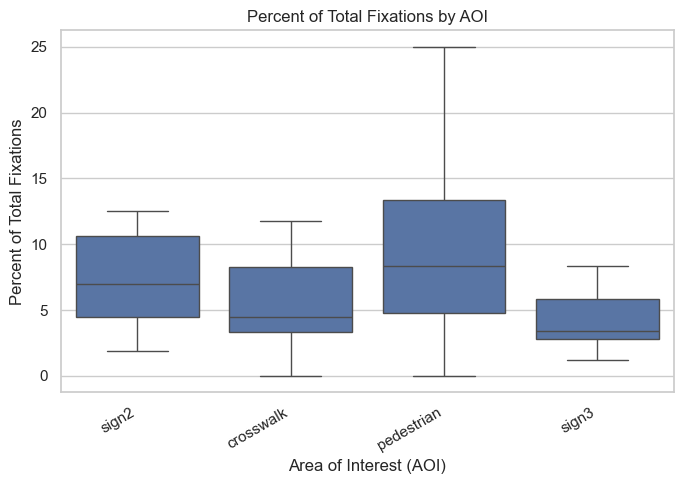

In [23]:
df = pd.read_csv("Compiled Eye Tracker Data.csv")

summary_stats = df.groupby("aoi")["percent_of_total_fixations"].agg(['mean', 'std']).sort_values(by="mean")
print(summary_stats.round(2))

sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))

sns.boxplot(
    data=df,
    x="aoi",
    y="percent_of_total_fixations",
    showfliers=False
)

plt.title("Percent of Total Fixations by AOI")
plt.ylabel("Percent of Total Fixations")
plt.xlabel("Area of Interest (AOI)")
plt.xticks(rotation=30, ha='right')
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

## Metric 2: Average Fixation Duration

For each AOI, calculate the average duration of a fixation on it, based on the fixations that were manually logged.


In [10]:
avg_durations = {}

for _, row in fixation_df.iterrows():
    participant = row['participant']
    trial = str(row['trial'])

    aoi_columns = {
        'sign2': row.get('sign2_fixations'),
        'sign3': row.get('sign3_fixations'),
        'crosswalk': row.get('crosswalk_fixations'),
        'pedestrian': row.get('ped_fixations')
    }

    for aoi, val in aoi_columns.items():
        durations = get_fixation_durations(val)

        # skip N/A
        if durations is None:
            continue

        avg_duration = np.mean(durations) if durations else 0
        avg_durations[(participant, trial, aoi)] = round(avg_duration, 2)

compiled_df = pd.read_csv('Compiled Eye Tracker Data.csv')

# add new column for average fixation duration for each trial/participant combo, for AOIs where fixations were relevant
compiled_df['average_fixation_duration'] = compiled_df.apply(
    lambda row: avg_durations.get((row['participant'], str(row['trial']), row['aoi']), np.nan),
    axis=1
)

compiled_df.to_csv('Compiled Eye Tracker Data.csv', index=False)

Visualize:


             mean    std
aoi                     
crosswalk   393.0  177.0
sign2       593.0  464.0
pedestrian  598.0  479.0
sign3       733.0  436.0


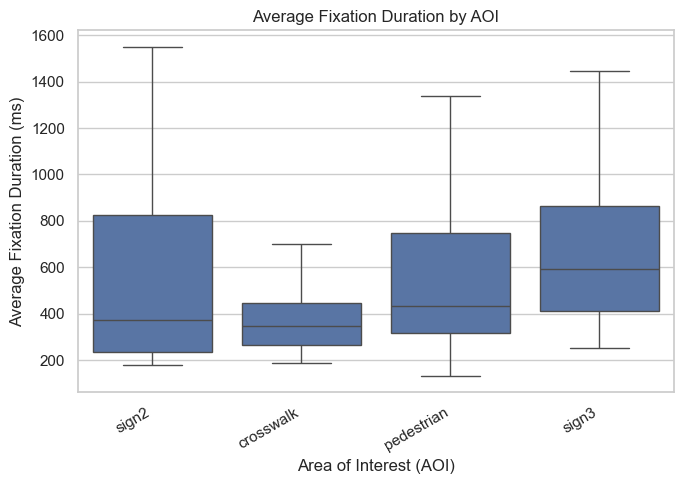

In [21]:
df = pd.read_csv("Compiled Eye Tracker Data.csv")

summary_stats = df.groupby("aoi")["average_fixation_duration"].agg(['mean', 'std']).sort_values(by="mean")
print(summary_stats.round(0))

sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))

sns.boxplot(
    data=df,
    x="aoi",
    y="average_fixation_duration",
    showfliers=False
)

plt.title("Average Fixation Duration by AOI")
plt.ylabel("Average Fixation Duration (ms)")
plt.xlabel("Area of Interest (AOI)")
plt.xticks(rotation=30, ha='right')
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

## Metric 3: Time to First Fixation (TFF)

Record the time to first fixation for the pedestrian, from a reference point where the crosswalk first comes into view, to when the driver first fixates on the pedestrian.


In [12]:
compiled_path = 'Compiled Eye Tracker Data.csv'
compiled_df = pd.read_csv(compiled_path)

fixation_df = pd.read_csv('Eye Tracker Data/Eye Tracker Fixation Timestamps.csv')
fixation_df.columns = fixation_df.columns.str.strip()

ped_lookup = {
    (row['participant'], str(row['trial'])): {
        'start': row['ped_visible_t_start'],
        'fixations': row['ped_fixations']
    }
    for _, row in fixation_df.iterrows()
}

# calculate TFF and record only to rows with pedestrian AOI
def get_tff(row):
    if row['aoi'] != 'pedestrian':
        return "N/A"
    
    key = (row['participant'], str(row['trial']))
    ped_data = ped_lookup.get(key)
    if not ped_data:
        return "N/A"
    
    return compute_tff(ped_data['fixations'], ped_data['start'])

compiled_df['tff'] = compiled_df.apply(get_tff, axis=1)

compiled_df.to_csv(compiled_path, index=False)

Repeated-measures ANOVA to determine if the alert combination type had a significant effect on the pedestrian TFF (i.e. did any alerts help the driver notice the pedestrian faster)?


In [15]:
df = pd.read_csv('Compiled Eye Tracker Data.csv')

# Filter only entries with pedestrian as AOI, and with valid numeric TFF
ped_df = df[
    (df['aoi'] == 'pedestrian') &
    (~df['tff'].isin(['N/A', 'No fixations']))
].copy()

ped_df['tff'] = pd.to_numeric(ped_df['tff'], errors='coerce')
ped_df.dropna(subset=['tff'], inplace=True)

ped_df['participant'] = ped_df['participant'].astype(str)

anova_results = pg.rm_anova(
    dv="tff", 
    within="alert_combination",
    subject="participant", 
    data=ped_df, 
    detailed=True,
)

print(anova_results)

              Source            SS  DF            MS         F    p-unc  \
0  alert_combination  1.682668e+07   5  3.365335e+06  0.973195  0.51153   
1              Error  1.729013e+07   5  3.458026e+06       NaN      NaN   

        ng2  eps  
0  0.482448  0.2  
1       NaN  NaN  


Visual:


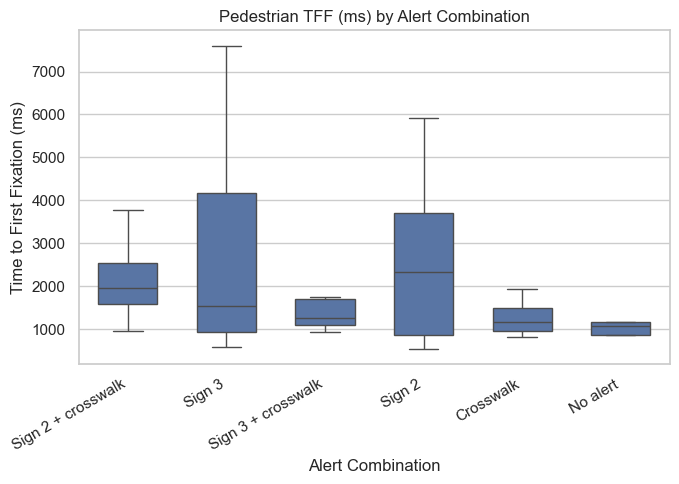

In [ ]:
df = pd.read_csv('Compiled Eye Tracker Data.csv')

plot_df = df[
    (df['aoi'] == 'pedestrian') &
    (~df['tff'].isin(['N/A', 'No fixations']))
].copy()

plot_df['tff'] = pd.to_numeric(plot_df['tff'], errors='coerce')
plot_df.dropna(subset=['tff'], inplace=True)
plot_df['participant'] = plot_df['participant'].astype(str)

sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))

sns.boxplot(
    data=plot_df,
    x="alert_combination",
    y="tff",
    width=0.6,
    showfliers=False
)

plt.title("Pedestrian TFF (ms) by Alert Combination")
plt.ylabel("Time to First Fixation (ms)")
plt.xlabel("Alert Combination")
plt.xticks(rotation=30, ha='right')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()